In [25]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d


import matplotlib.pyplot as plt
from scipy.stats import norm

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# 被験者ID
subject_id = "001"
# 実験番号
experiment_id = "001"

# IDT法のパラメータ
DISPERSION_THRESHOLD = 1.5  # deg
DURATION_THRESHOLD_MS = 100  # ms

eye_df = pd.read_csv(f"exported_csv/eye_df_id{subject_id}-{experiment_id}.csv")
sampling_df = pd.read_csv(f"exported_csv/sampling_df_id{subject_id}-{experiment_id}.csv")

In [26]:

# モニターサイズ(物理)
monitor_width_cm = 47.6
monitor_height_cm = 26.8
# モニター解像度(px)
monitor_resolution_px = (1920, 1080)
# 視距離(cm)
viewer_distance_cm = 60.0

# cm/pxの変換係数
cm_per_pixel_x = monitor_width_cm / monitor_resolution_px[0]
cm_per_pixel_y = monitor_height_cm / monitor_resolution_px[1]

# ディスプレイ中心を(0, 0)とするための変換
eye_df["gx_centered"] = eye_df["gx"] - 0.5
eye_df["gy_centered"] = eye_df["gy"] - 0.5

# 中心(0,0)での物理距離変換
eye_df["x_cm"] = eye_df["gx_centered"] * monitor_resolution_px[0] * cm_per_pixel_x
eye_df["y_cm"] = eye_df["gy_centered"] * monitor_resolution_px[1] * cm_per_pixel_y

# 視野角の計算
eye_df["x_deg"] = np.degrees(np.arctan2(eye_df["x_cm"], viewer_distance_cm))
eye_df["y_deg"] = np.degrees(np.arctan2(eye_df["y_cm"], viewer_distance_cm))

# データの有効性
eye_df["is_valid"] = eye_df["validity_sum"] > 1

print(eye_df.head())


         gx        gy     epoch_sec        hhmmss  validity_sum  trial  \
0       NaN       NaN  1.732521e+09  16:49:03.491             0     -1   
1  0.476050  0.816155  1.732521e+09  16:49:03.506             2     -1   
2  0.490610  0.818481  1.732521e+09  16:49:03.522             2     -1   
3  0.520527  0.754540  1.732521e+09  16:49:03.538             2     -1   
4  0.507679  0.780874  1.732521e+09  16:49:03.538             2     -1   

   gx_centered  gy_centered      x_cm      y_cm     x_deg     y_deg  is_valid  
0          NaN          NaN       NaN       NaN       NaN       NaN     False  
1    -0.023950     0.316155 -1.140020  8.472954 -1.088508  8.037926      True  
2    -0.009390     0.318481 -0.446964  8.535291 -0.426811  8.096281      True  
3     0.020527     0.254540  0.977085  6.821672  0.932965  6.486364      True  
4     0.007679     0.280874  0.365520  7.527423  0.349042  7.150799      True  


In [27]:
def interpolate_missing(df, time_col="epoch_sec", max_gap_ms=100):
    df= df.copy()
    df["valid"]= df["is_valid"]
    df["interp_x"]= np.nan
    df["interp_y"]= np.nan

    # 有効データを代入
    df.loc[df["valid"], "interp_x"] = df.loc[df["valid"], "x_deg"]
    df.loc[df["valid"], "interp_y"] = df.loc[df["valid"], "y_deg"]
    
    # 内部のみ線形補完
    df["interp_x"] = df["interp_x"].interpolate(limit_area="inside")
    df["interp_y"] = df["interp_y"].interpolate(limit_area="inside")
    
    # 無効区間の連続ブロックを取得
    invalid_mask = ~df["valid"]
    group_id = (invalid_mask != invalid_mask.shift()).cumsum()
    invalid_blocks = df[invalid_mask].groupby(group_id)

    for _, block in invalid_blocks:
        if len(block) == 0:
            continue
        t_start = block[time_col].iloc[0]
        t_end = block[time_col].iloc[-1]
        duration_ms = (t_end - t_start) * 1000
        if duration_ms > max_gap_ms:
            # 100ms超えたら補完結果をNaNに戻す
            df.loc[block.index, ["interp_x", "interp_y"]] = np.nan
    

    return df
    
    

In [28]:
def apply_gaussian_filter_by_block(df, col_x="x_deg", col_y="y_deg", sigma=1.0):
    df = df.copy()
    df["valid"]= df["is_valid"]
    df["filtered_x"] = np.nan
    df["filtered_y"] = np.nan

    # 有効なデータ（NaNでない）だけを連続ブロックとして抽出
    valid_mask = df[col_x].notna() & df[col_y].notna()
    block_id = (valid_mask != valid_mask.shift()).cumsum()
    blocks = df[valid_mask].groupby(block_id)

    for _, block in blocks:
        idx = block.index
        smoothed_x = gaussian_filter1d(block[col_x], sigma=sigma)
        smoothed_y = gaussian_filter1d(block[col_y], sigma=sigma)
        df.loc[idx, "filtered_x"] = smoothed_x
        df.loc[idx, "filtered_y"] = smoothed_y

    return df


In [29]:
def detect_fixations_idt(df, dispersion_threshold=DISPERSION_THRESHOLD , duration_threshold_ms=DURATION_THRESHOLD_MS):
    fixations = []
    timestamps = df["epoch_sec"].to_numpy()
    xs = df["filtered_x"].to_numpy()
    ys = df["filtered_y"].to_numpy()
    
    i=0
    while i < len(df):
        if np.isnan(xs[i]) or np.isnan(ys[i]):
            i += 1
            continue
        
        window = [(xs[i], ys[i])]
        t_start = timestamps[i]
        j = i + 1
        
        while j < len(df):
            if np.isnan(xs[j]) or np.isnan(ys[j]):
                break
            window.append((xs[j], ys[j]))
            t_end = timestamps[j]
            duration = (t_end - t_start) * 1000
            
            x_vals, y_vals = zip(*window)
            x_center = np.mean(x_vals)
            y_center = np.mean(y_vals)
            
            distances = np.sqrt((np.array(x_vals) - x_center) ** 2 + (np.array(y_vals) - y_center) ** 2)
            
            if np.max(distances) > dispersion_threshold:
                break
            if duration >= duration_threshold_ms:
                fixations.append({
                    "start_time": t_start,
                    "end_time": t_end,
                    "duration_ms": duration,
                    "x_mean_deg": np.mean(x_vals),
                    "y_mean_deg": np.mean(y_vals),
                })
            j += 1
        i = j
    return pd.DataFrame(fixations)
    

In [30]:
def deg_to_px(x_deg, y_deg):
    x_cm = np.tan(np.radians(x_deg)) * viewer_distance_cm
    y_cm = np.tan(np.radians(y_deg)) * viewer_distance_cm
    
    x_px = (x_cm / cm_per_pixel_x) + (monitor_resolution_px[0] / 2)
    y_px = (y_cm / cm_per_pixel_y) + (monitor_resolution_px[1] / 2)
    
    return x_px, y_px
    

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
        start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0     1.732521e+09  1.732521e+09   111.000061   -2.941823    0.464670    0.0   
1     1.732521e+09  1.732521e+09   127.000093   -2.923862    0.385860    0.0   
2     1.732521e+09  1.732521e+09   143.000126   -2.911590    0.323350    0.0   
3     1.732521e+09  1.732521e+09   157.999992   -2.902285    0.273381    0.0   
4     1.732521e+09  1.732521e+09   174.000025   -2.891301    0.231764    0.0   
...            ...           ...          ...         ...         ...    ...   
1098  1.732521e+09  1.732521e+09   207.000017   -7.359209   -7.533635    0.0   
1099  1.732521e+09  1.732521e+09   223.000050   -7.348805   -7.530070    0.0   
1100  1.732521e+09  1.732521e+09   239.000082   -7.338641   -7.526319    0.0   
1101  1.732521e+09  1.732521e+09   255.000114 

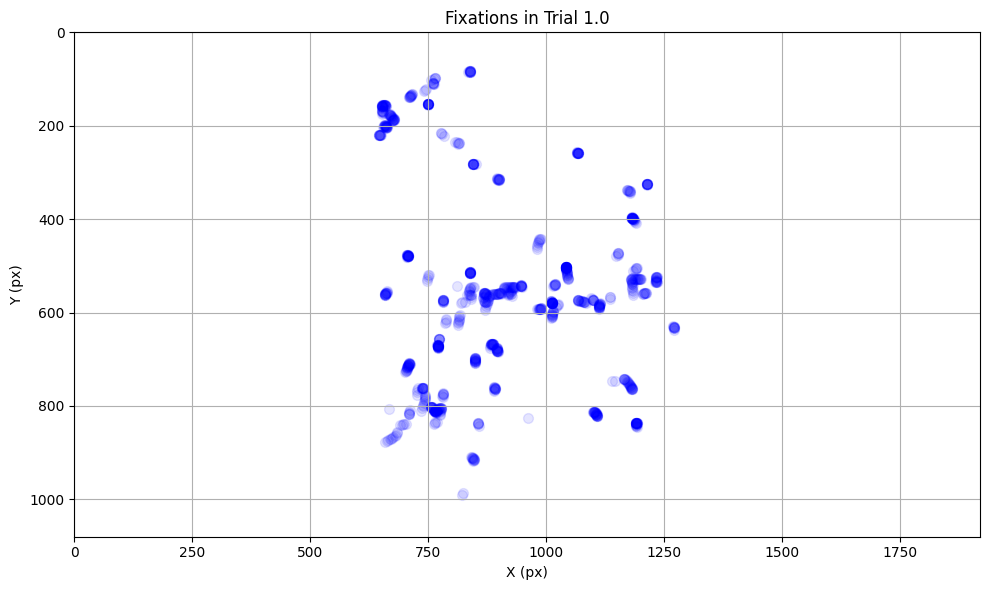

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
        start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0     1.732521e+09  1.732521e+09   110.999823   -0.203362    0.273317    1.0   
1     1.732521e+09  1.732521e+09   126.999855   -0.213883    0.266287    1.0   
2     1.732521e+09  1.732521e+09   142.999887   -0.220232    0.260371    1.0   
3     1.732521e+09  1.732521e+09   158.999920   -0.220108    0.258745    1.0   
4     1.732521e+09  1.732521e+09   174.999952   -0.216430    0.255302    1.0   
...            ...           ...          ...         ...         ...    ...   
1111  1.732521e+09  1.732521e+09   144.000053   -1.737986    0.622269    1.0   
1112  1.732521e+09  1.732521e+09   160.000086   -1.723539    0.617305    1.0   
1113  1.732521e+09  1.732521e+09   173.000097   -1.711841    0.609527    1.0   
1114  1.732521e+09  1.732521e+09   190.999985 

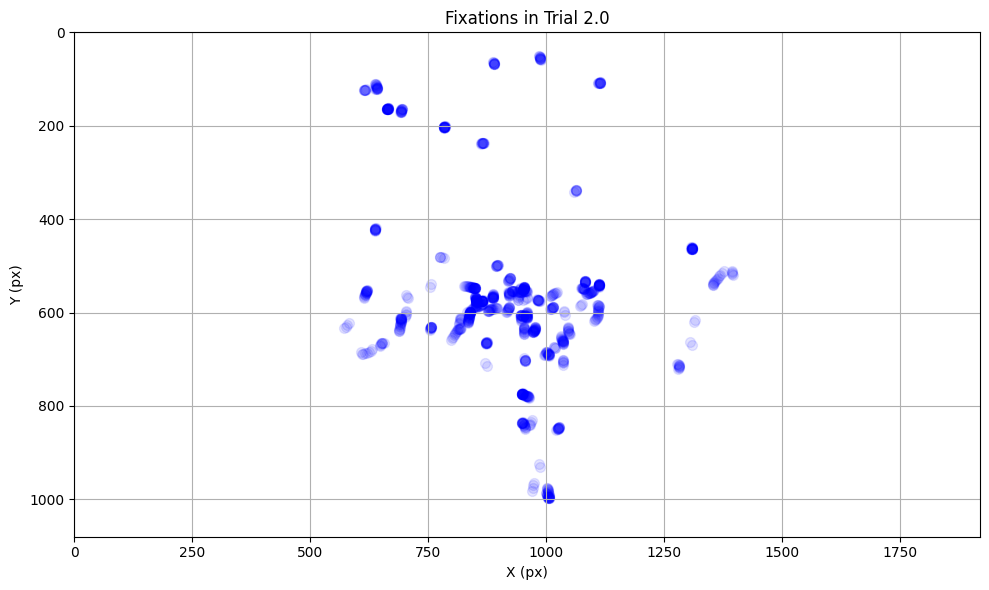

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
       start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0    1.732521e+09  1.732521e+09   111.999989   -0.195460    0.671657    2.0   
1    1.732521e+09  1.732521e+09   128.000021   -0.144435    0.750378    2.0   
2    1.732521e+09  1.732521e+09   111.000061   -7.321975    1.774313    2.0   
3    1.732521e+09  1.732521e+09   126.000166   -7.274575    1.742054    2.0   
4    1.732521e+09  1.732521e+09   141.999960   -7.210518    1.684002    2.0   
..            ...           ...          ...         ...         ...    ...   
902  1.732521e+09  1.732521e+09   747.999907    1.042325    6.570053    2.0   
903  1.732521e+09  1.732521e+09   763.000011    1.048459    6.576035    2.0   
904  1.732521e+09  1.732521e+09   779.000044    1.054638    6.581201    2.0   
905  1.732521e+09  1.732521e+09   795.000076    1.058774

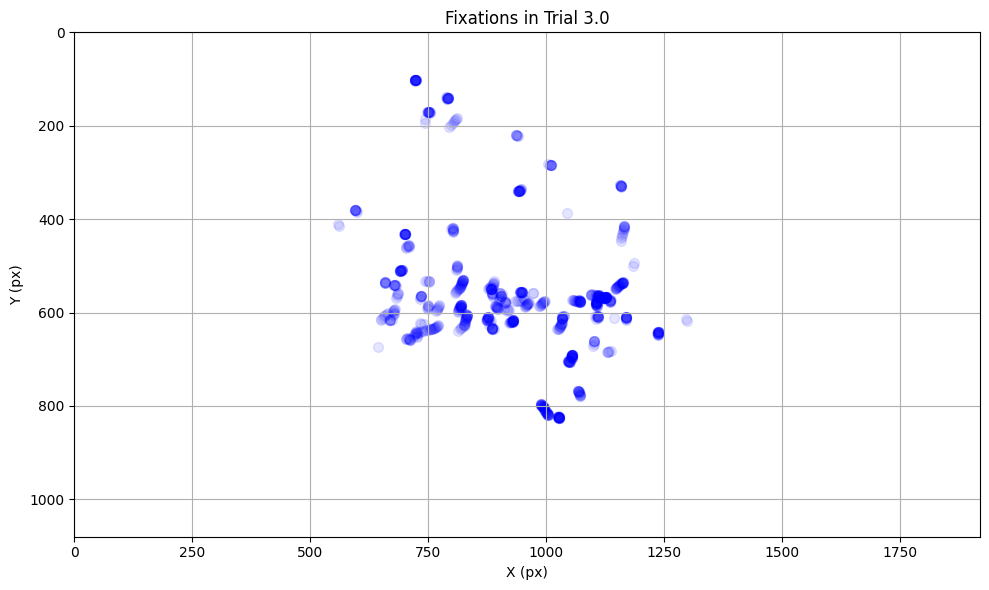

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
        start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0     1.732521e+09  1.732521e+09   111.999989   -0.868595    0.350131    3.0   
1     1.732521e+09  1.732521e+09   111.999989   -0.879379    0.356553    3.0   
2     1.732521e+09  1.732521e+09   111.999989   -0.876448    0.353684    3.0   
3     1.732521e+09  1.732521e+09   128.000021   -0.848192    0.349951    3.0   
4     1.732521e+09  1.732521e+09   143.999815   -0.788791    0.351255    3.0   
...            ...           ...          ...         ...         ...    ...   
1053  1.732521e+09  1.732521e+09   495.999813   -8.465025   -0.040543    3.0   
1054  1.732521e+09  1.732521e+09   511.999846   -8.481856   -0.039796    3.0   
1055  1.732521e+09  1.732521e+09   527.999878   -8.499430   -0.039195    3.0   
1056  1.732521e+09  1.732521e+09   543.999910 

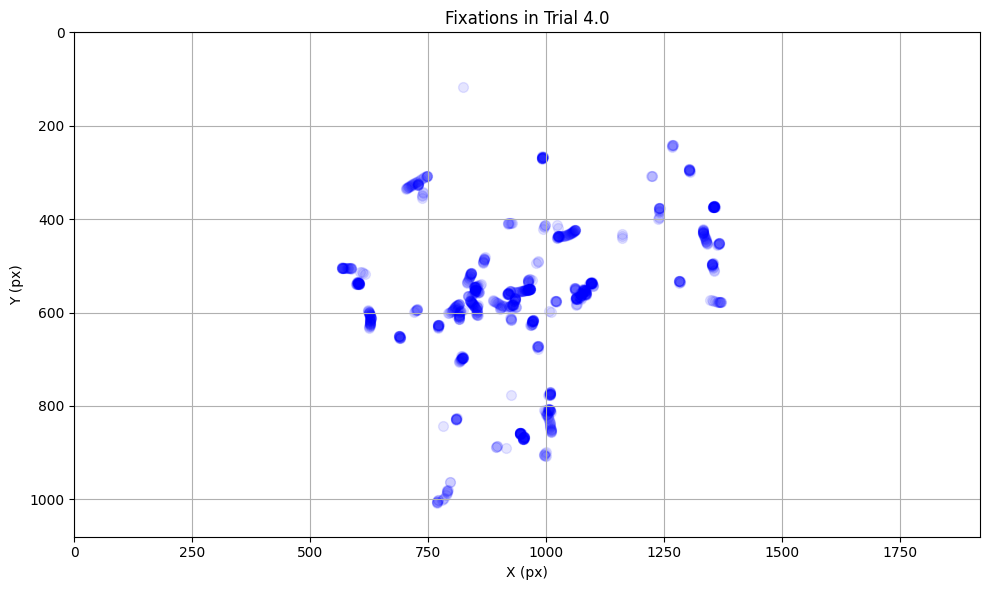

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
        start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0     1.732521e+09  1.732521e+09   111.999989   -1.940501   -1.195126    4.0   
1     1.732521e+09  1.732521e+09   127.000093   -1.950107   -1.056722    4.0   
2     1.732521e+09  1.732521e+09   111.999989   -2.106809   -1.135517    4.0   
3     1.732521e+09  1.732521e+09   111.999989   -2.044576   -1.127826    4.0   
4     1.732521e+09  1.732521e+09   128.000021   -1.955392   -1.084213    4.0   
...            ...           ...          ...         ...         ...    ...   
1038  1.732521e+09  1.732521e+09   190.999985    7.962245    0.973598    4.0   
1039  1.732521e+09  1.732521e+09   110.999823   -7.772143    0.777120    4.0   
1040  1.732521e+09  1.732521e+09   126.999855   -7.795759    0.787392    4.0   
1041  1.732521e+09  1.732521e+09   142.999887 

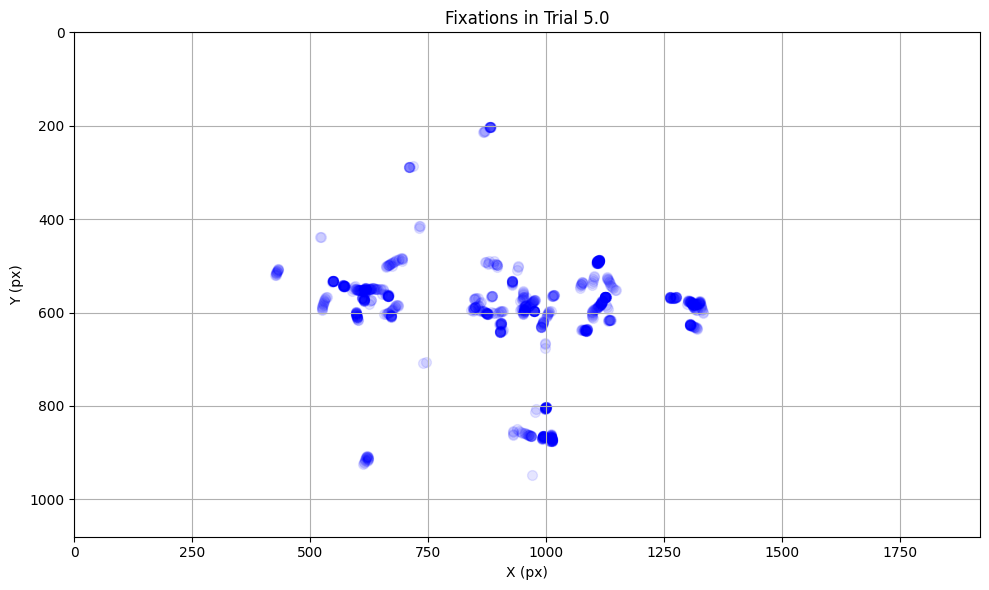

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
       start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0    1.732521e+09  1.732521e+09   111.000061   -3.164468    1.340779    5.0   
1    1.732521e+09  1.732521e+09   126.999855   -3.172673    1.343044    5.0   
2    1.732521e+09  1.732521e+09   142.999887   -3.185731    1.350859    5.0   
3    1.732521e+09  1.732521e+09   158.999920   -3.202816    1.363966    5.0   
4    1.732521e+09  1.732521e+09   174.000025   -3.219789    1.376565    5.0   
..            ...           ...          ...         ...         ...    ...   
918  1.732521e+09  1.732521e+09   159.999847    1.959191    1.847063    5.0   
919  1.732521e+09  1.732521e+09   175.999880    1.946791    1.784235    5.0   
920  1.732521e+09  1.732521e+09   191.999912    1.938357    1.718422    5.0   
921  1.732521e+09  1.732521e+09   207.999945    1.931468

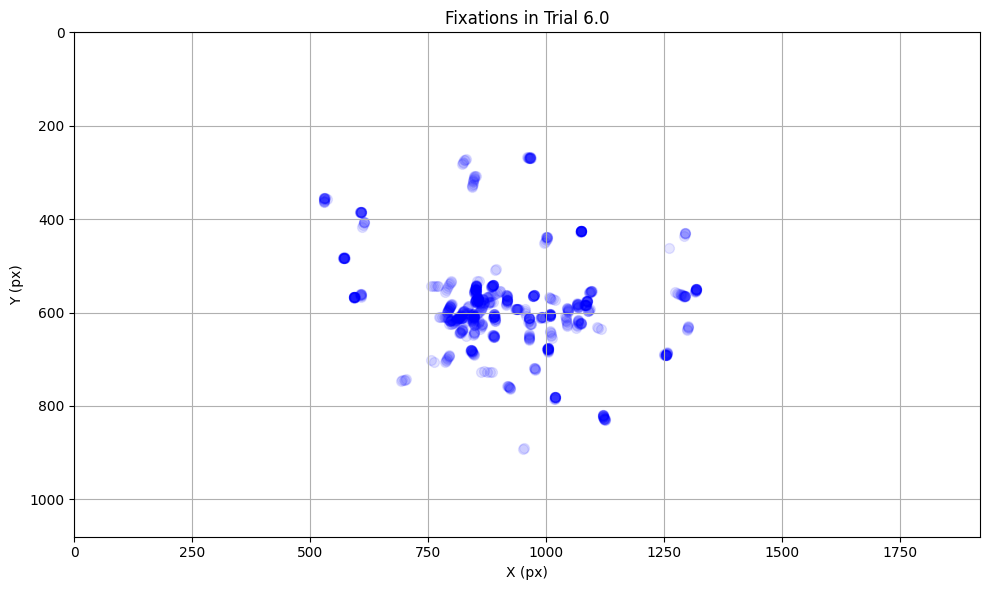

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
       start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0    1.732521e+09  1.732521e+09   111.999989   -0.653763    1.879746    6.0   
1    1.732521e+09  1.732521e+09   128.000021   -0.643337    1.770211    6.0   
2    1.732521e+09  1.732521e+09   144.000053   -0.638309    1.671861    6.0   
3    1.732521e+09  1.732521e+09   159.999847   -0.636537    1.581571    6.0   
4    1.732521e+09  1.732521e+09   175.999880   -0.638716    1.506081    6.0   
..            ...           ...          ...         ...         ...    ...   
920  1.732522e+09  1.732522e+09   223.000050    2.756388    6.456346    6.0   
921  1.732522e+09  1.732522e+09   239.000082    2.737177    6.470402    6.0   
922  1.732522e+09  1.732522e+09   255.000114    2.698577    6.491229    6.0   
923  1.732522e+09  1.732522e+09   271.000147    2.639150

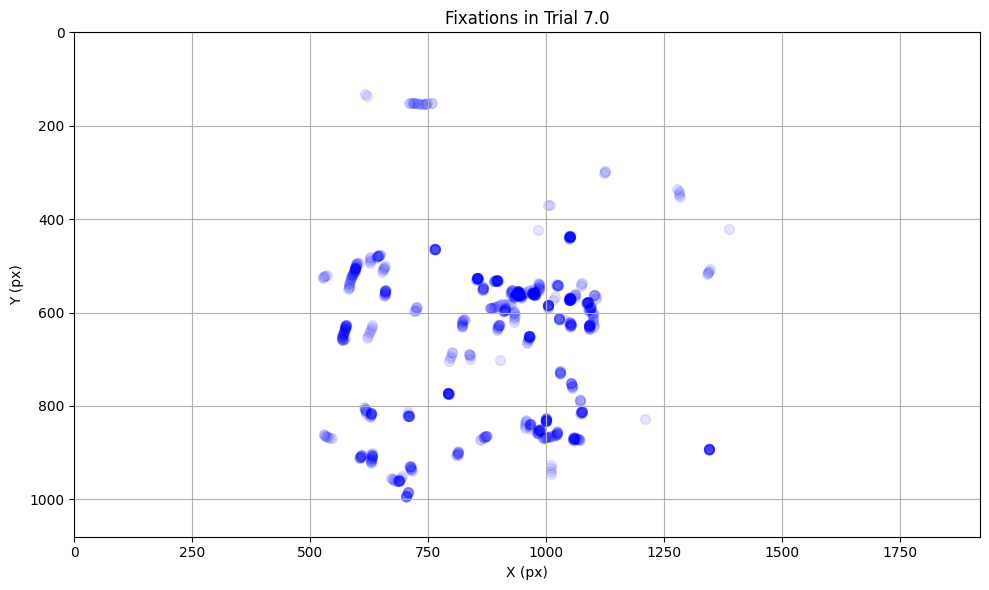

**************************************
Index(['start_time', 'end_time', 'duration_ms', 'x_mean_deg', 'y_mean_deg',
       'trial'],
      dtype='object')
       start_time      end_time  duration_ms  x_mean_deg  y_mean_deg  trial  \
0    1.732522e+09  1.732522e+09   110.000134   -0.902880    0.385719    7.0   
1    1.732522e+09  1.732522e+09   126.000166   -0.892439    0.401706    7.0   
2    1.732522e+09  1.732522e+09   141.000032   -0.888508    0.417073    7.0   
3    1.732522e+09  1.732522e+09   156.000137   -0.887588    0.434881    7.0   
4    1.732522e+09  1.732522e+09   172.000170   -0.887149    0.460060    7.0   
..            ...           ...          ...         ...         ...    ...   
858  1.732522e+09  1.732522e+09   222.000122   -1.282188    0.513162    7.0   
859  1.732522e+09  1.732522e+09   237.999916   -1.279665    0.488888    7.0   
860  1.732522e+09  1.732522e+09   253.999949   -1.281411    0.467096    7.0   
861  1.732522e+09  1.732522e+09   269.999981   -1.291729

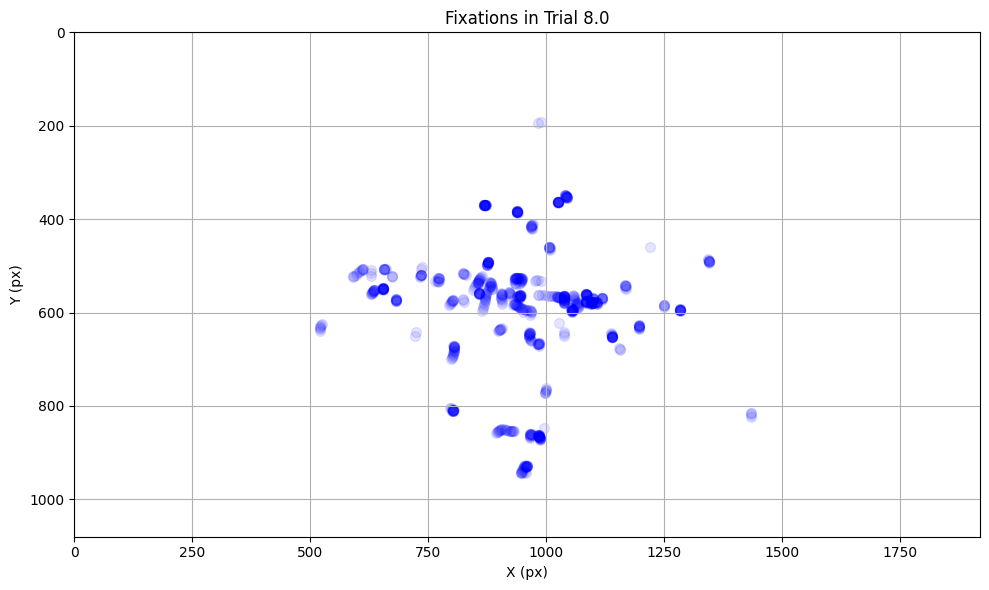

In [31]:
# === トライアルごとの処理 + プロット ===
all_fixations = []

for _, row in sampling_df.iterrows():
    t_start = row["start_sec"]
    t_end = row["end_sec"]
    trial_num = row["trial"]

    df_trial = eye_df[(eye_df["epoch_sec"] >= t_start) & (eye_df["epoch_sec"] <= t_end)]
    df_interp = interpolate_missing(df_trial)
    df_filtered= apply_gaussian_filter_by_block(df_interp)
    fix_df = detect_fixations_idt(df_filtered, DISPERSION_THRESHOLD, DURATION_THRESHOLD_MS)
    
    if fix_df.empty:
        print(f"Trial {trial_num}: No fixations detected.")
        continue
    
    fix_df["trial"] = trial_num

    print("**************************************")
    print(fix_df.columns)

    
    # 座標変換
    fix_df["x_px"], fix_df["y_px"] = deg_to_px(fix_df["x_mean_deg"], fix_df["y_mean_deg"])

    all_fixations.append(fix_df)

    print(fix_df)

    # プロット
    plt.figure(figsize=(10, 6))
    plt.scatter(fix_df["x_px"], fix_df["y_px"], alpha=0.1,c='blue', s=50)
    plt.xlim(0, monitor_resolution_px[0])
    plt.ylim(monitor_resolution_px[1], 0)  # y軸を上向きに
    plt.title(f"Fixations in Trial {trial_num+1}")
    plt.xlabel("X (px)")
    plt.ylabel("Y (px)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [32]:
new1_df=interpolate_missing(eye_df)
# print(new1_df.head())
new2_df=apply_gaussian_filter_by_block(new1_df)
new3_df=detect_fixations_idt(new2_df)
deg_to_px(new3_df["x_mean_deg"], new3_df["y_mean_deg"])

(0        1047.401466
 1        1046.422196
 2        1044.521648
 3        1042.403810
 4        1041.868647
             ...     
 17048     457.635808
 17049     456.491185
 17050     455.737861
 17051     493.527041
 17052     489.367396
 Name: x_mean_deg, Length: 17053, dtype: float64,
 0         891.851246
 1         888.655095
 2         886.447517
 3         886.263308
 4         889.123436
             ...     
 17048    1182.982236
 17049    1185.735146
 17050    1188.757964
 17051    1246.725033
 17052    1247.584128
 Name: y_mean_deg, Length: 17053, dtype: float64)